In [39]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML


from pathlib import Path
from scipy import sparse
from sklearn.metrics import roc_auc_score,accuracy_score
from xgboost.sklearn import XGBClassifier

from utils import plot_confusion_matrix

%matplotlib inline

from matplotlib.ticker import MultipleLocator

fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

r = 15
theta = 5
rw = 12
gamma = 0.1

xsize = 8
ysize = 5

cwd = os.getcwd()

data_path = Path(f'{cwd}/data')
report_path = Path(f'{cwd}/report')
figure_path = Path(f'{cwd}/figure')

In [15]:
X_train_sparse = sparse.load_npz(data_path / "npz_data/X_train_red.npz")
y_train = sparse.load_npz(data_path / "npz_data/y_train.npz").toarray().squeeze()
    
X_test_sparse = sparse.load_npz(data_path / "npz_data/X_test_red.npz")
y_test = sparse.load_npz(data_path / "npz_data/y_test.npz").toarray().squeeze()

X_train = X_train_sparse.toarray()
X_test = X_test_sparse.toarray()

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis = 0)

In [17]:
xgb_model = list(report_path.glob('check_point_2023-05-22-14-18/xgb.json'))[0]

best_model = XGBClassifier()
best_model.load_model(xgb_model)
y_train_pred = best_model.predict(X_train_sparse)
y_test_pred = best_model.predict(X_test_sparse)
y_train_prob_pred = best_model.predict_proba(X_train_sparse)[:,1]
y_test_prob_pred = best_model.predict_proba(X_test_sparse)[:,1]

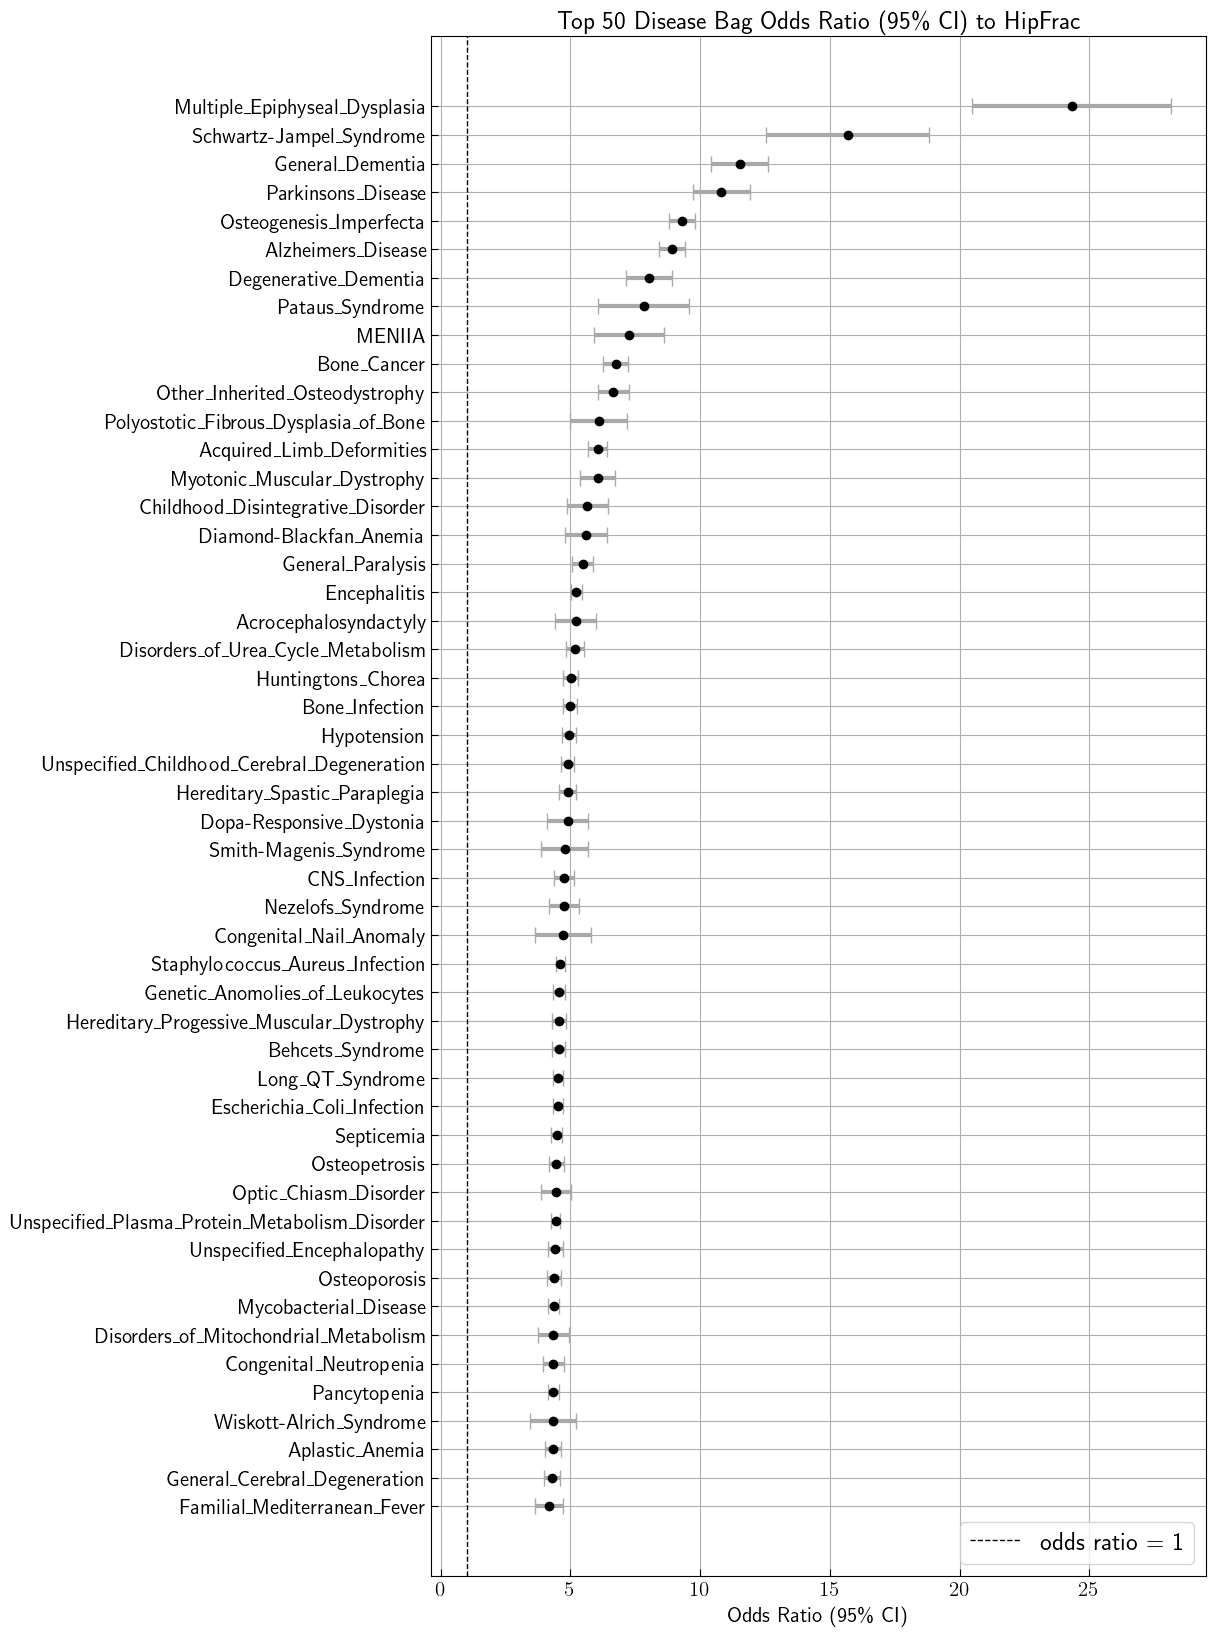

In [75]:
df = pd.read_csv(data_path / "HipFracOR_T2D_0501.csv")
df.sort_values(by = "odds_ratio", inplace=True)

x = df['disease'].tail(50)
y = df['odds_ratio'].tail(50)
err = df['CI'].tail(50)

fig, ax = plt.subplots(figsize = (10,20))
ax.errorbar(y, x, xerr=[err, err], fmt='o', color='black',
             ecolor='darkgray', 
             elinewidth=3, 
              capsize=6)

# Set labels and title with custom font size
ax.set_xlabel('Odds Ratio (95\% CI)')
# ax.set_ylabel('Disease')

# Set custom tick label font size for the subplot
ax.tick_params(axis='x')
ax.tick_params(axis='y')

ax.set_title("Top 50 Disease Bag Odds Ratio (95\% CI) to HipFrac")

ax.axvline(x=1, color='black', linestyle='--', linewidth=1, label = "odds ratio = 1")
ax.legend(loc = "lower right")


# Show the plot
plt.grid()
plt.show()

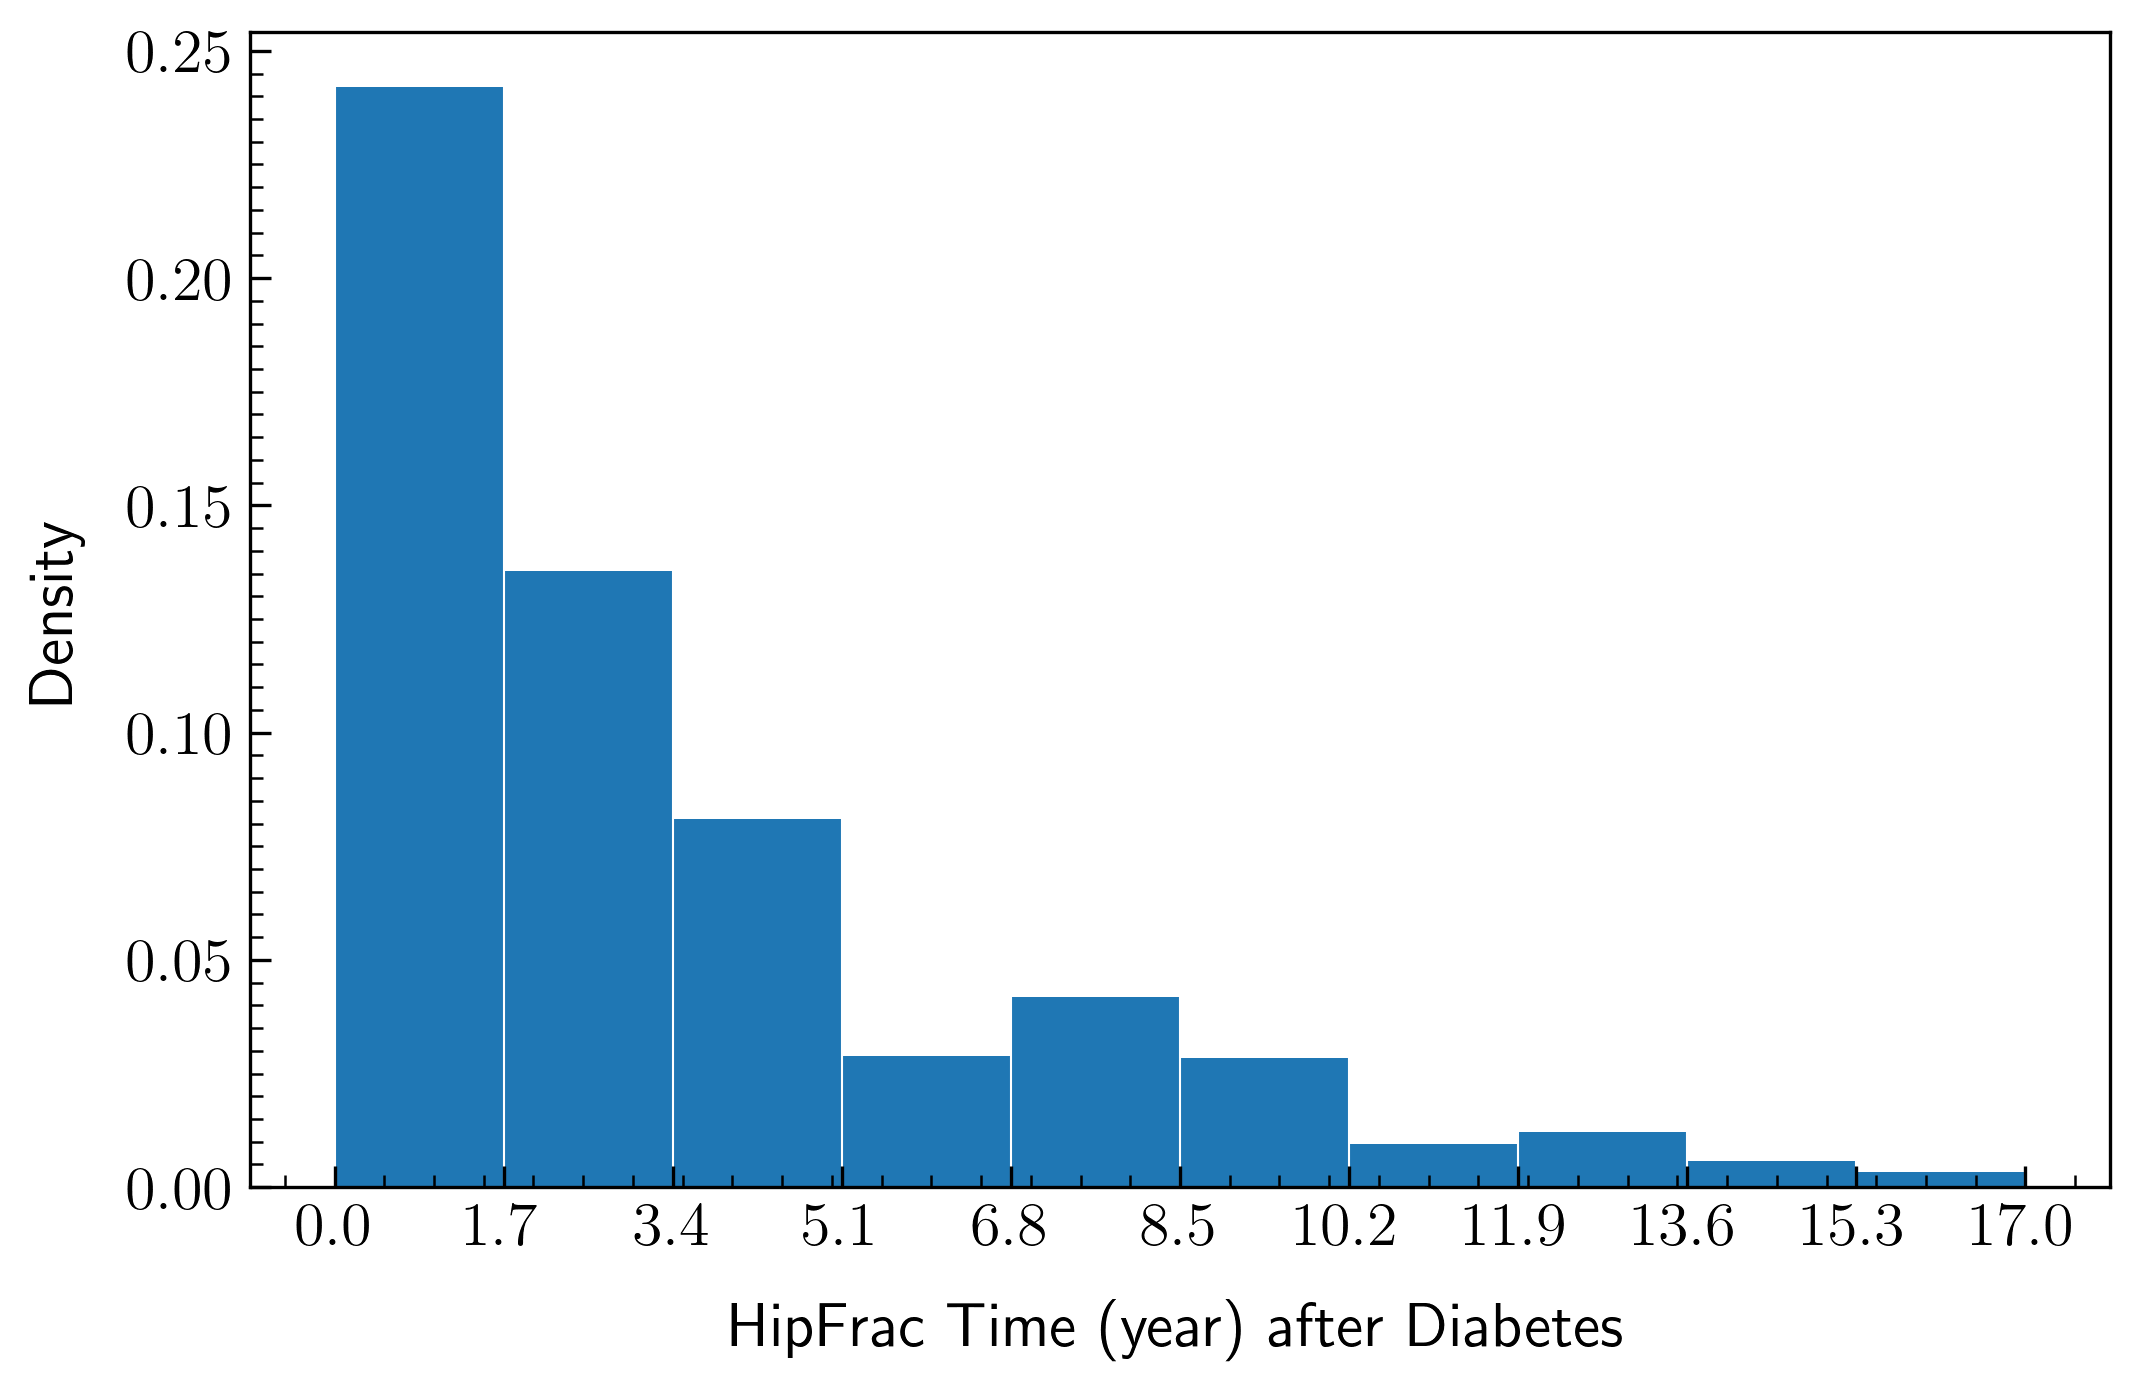

In [12]:
display(Image(filename=figure_path/"time_decay_HipFrac_plot.png"))

### 1. Confusion Matrix 

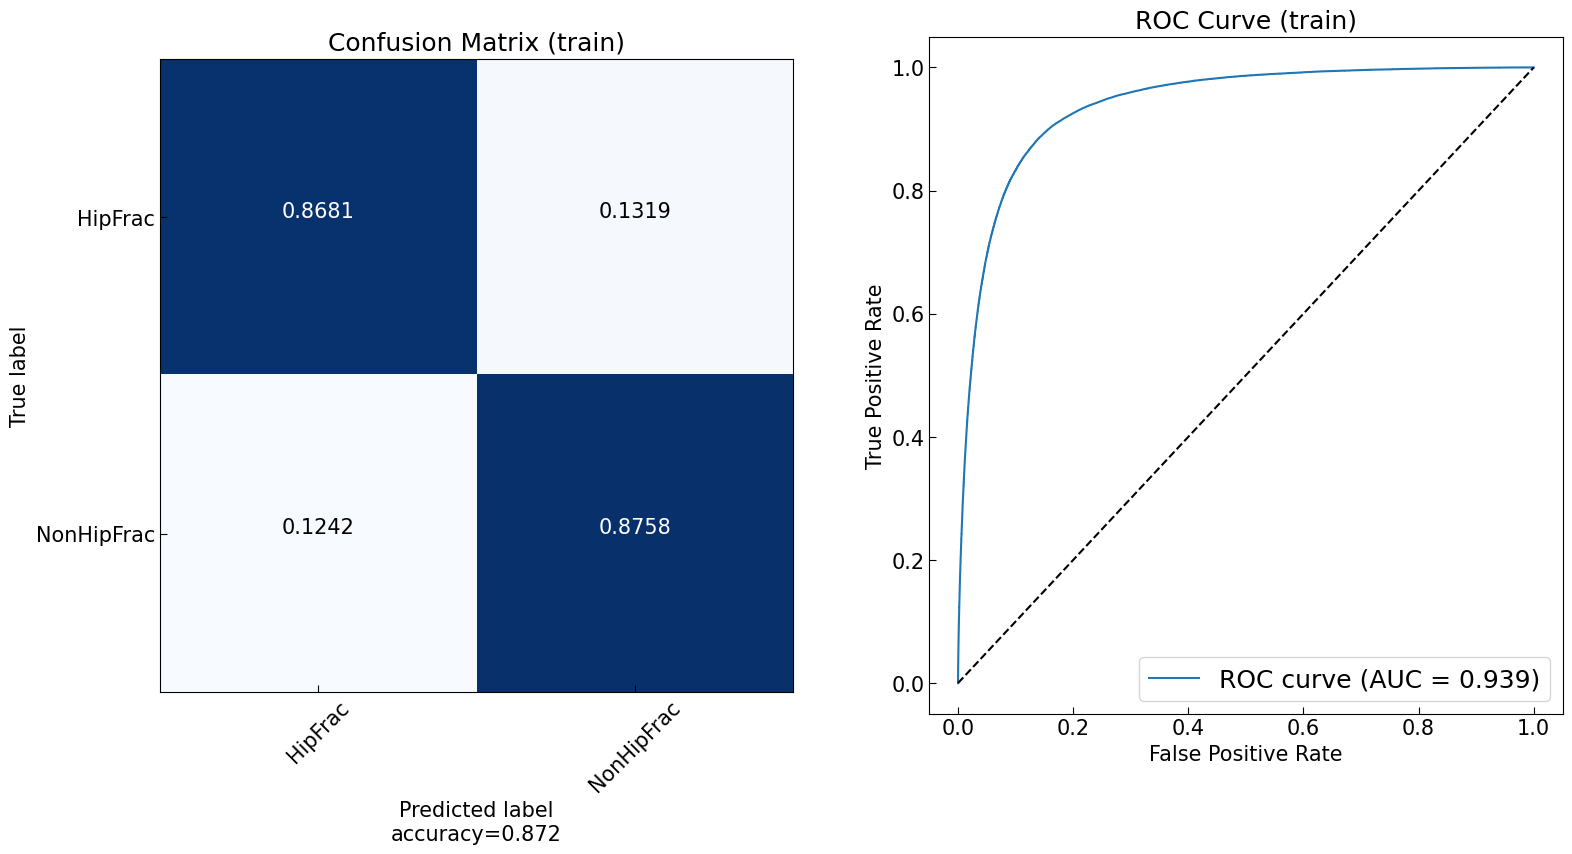

In [19]:
plot_confusion_matrix(y_train, y_train_pred, y_train_prob_pred, target_names=["HipFrac", "NonHipFrac"], title="train")

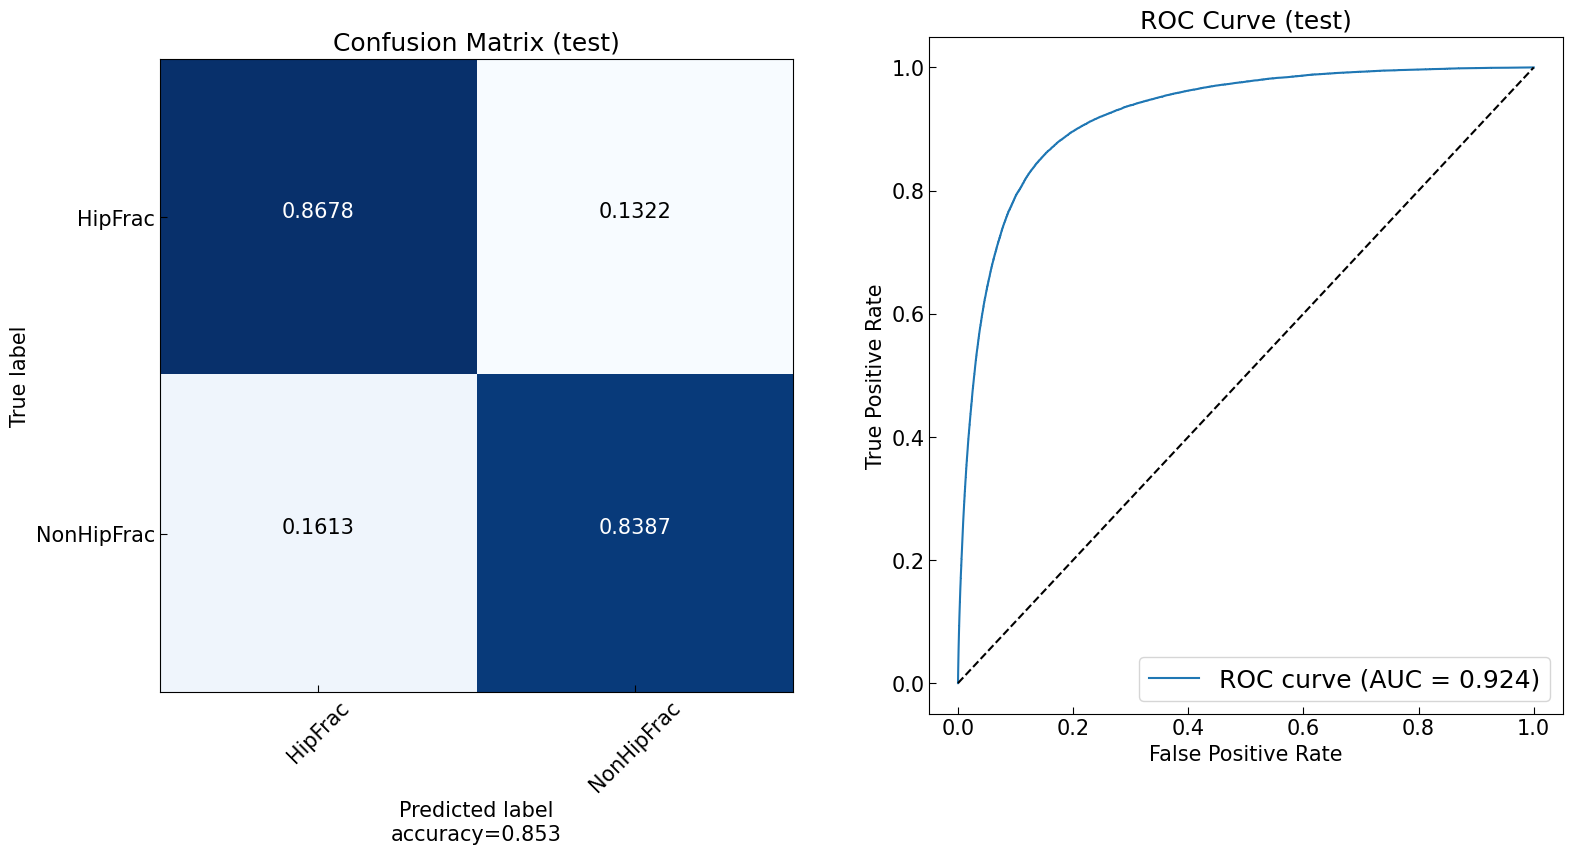

In [20]:
plot_confusion_matrix(y_test, y_test_pred, y_test_prob_pred, target_names=["HipFrac", "NonHipFrac"], title="test")

### 2. True Positive Rate 

In [18]:
X_sparse = sparse.csc_matrix(X)
y_hat= best_model.predict(X_sparse)

In [26]:
from sklearn.metrics import confusion_matrix
from statsmodels.stats.proportion import proportion_confint

def cal_stats(arr1, arr2):
    
    _, fp, fn, tp = confusion_matrix(arr1, arr2).ravel()
    tpr = tp / (tp + fn)

    # Compute confidence interval for TPR
    conf_interval_tpr = proportion_confint(count=tp, nobs=tp + fn, alpha=0.05, method='wilson')

    # Extract lower and upper bounds of the confidence interval
    tpr_lower_bound = conf_interval_tpr[0]
    tpr_upper_bound = conf_interval_tpr[1]

    return (tp,fp,tpr,tpr_lower_bound,tpr_upper_bound)

features = []
with open(data_path / "features.txt", "r") as f:
    for line in f:
        features.append(line.strip())

df_xgb_w = pd.DataFrame.from_dict({f: w for f,w in zip(features,best_model.feature_importances_)}, orient = "index", columns=['weight'])
df_xgb_w.sort_values(by = "weight", inplace = True, ascending = False)
df_xgb_w = df_xgb_w.reset_index().rename(columns={'index': 'Disease'})

df = {'Subgroups':[], 'Case': [], 'True Positive': [], 'False Positive': [], 'True Positive Rate (95% CI)': []}
case = {'Yes': 1, 'No': 0}

tpr_plot_df = {'tpr': [], 'tpr_upper': [], 'tpr_lower': []}

# gender 
df['Subgroups'].append('Sex')
df['Subgroups'].append('Sex')

df['Case'].append('Male')
df['Case'].append('Female')

dfi = pd.DataFrame({'sex': X[:,1], 'y': y, 'y_hat': y_hat})

tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(dfi[dfi['sex'] == 1]['y'], dfi[dfi['sex'] == 1]['y_hat'])
tpr_plot_df['tpr'].append(tpr)
tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
df['True Positive'].append(f'{tp:,}')
df['False Positive'].append(f'{fp:,}')
df['True Positive Rate (95% CI)'].append(tpr_str)

tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(dfi[dfi['sex'] == 0.5]['y'], dfi[dfi['sex'] == 0.5]['y_hat'])
tpr_plot_df['tpr'].append(tpr)
tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
df['True Positive'].append(f'{tp:,}')
df['False Positive'].append(f'{fp:,}')
df['True Positive Rate (95% CI)'].append(tpr_str)

#age 
df['Subgroups'].append('Age')
df['Subgroups'].append('Age')

df['Case'].append('>=65')
df['Case'].append('<65')

dfi = pd.DataFrame({'age': X[:,0], 'y': y, 'y_hat': y_hat})

tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(dfi[dfi['age'] >= 0.98]['y'], dfi[dfi['age'] >= 0.98]['y_hat'])
tpr_plot_df['tpr'].append(tpr)
tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
df['True Positive'].append(f'{tp:,}')
df['False Positive'].append(f'{fp:,}')
df['True Positive Rate (95% CI)'].append(tpr_str)

tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(dfi[dfi['age'] < 0.98]['y'], dfi[dfi['age'] < 0.98]['y_hat'])
tpr_plot_df['tpr'].append(tpr)
tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
df['True Positive'].append(f'{tp:,}')
df['False Positive'].append(f'{fp:,}')
df['True Positive Rate (95% CI)'].append(tpr_str)

# disease
for id_, dis in enumerate(df_xgb_w['Disease']):
    
    if (id_ > 28):
        break
    
    if (dis == 'dobyr') or (dis == 'sex'):
        continue 
    
    idx = features.index(dis)
    dfi = pd.DataFrame({dis: X[:,idx], 'y': y, 'y_hat': y_hat})
    
    for k,v in case.items():
        df['Subgroups'].append(dis)
        df['Case'].append(k)
        tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(dfi[dfi[dis] == v]['y'], dfi[dfi[dis] == v]['y_hat'])
        tpr_plot_df['tpr'].append(tpr)
        tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
        tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

        tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
        df['True Positive'].append(f'{tp:,}')
        df['False Positive'].append(f'{fp:,}')
        df['True Positive Rate (95% CI)'].append(tpr_str)
        
tp, fp, tpr,tpr_lower_bound,tpr_upper_bound = cal_stats(y,y_hat)
tpr_plot_df['tpr'].append(tpr)
tpr_plot_df['tpr_lower'].append(tpr_lower_bound)
tpr_plot_df['tpr_upper'].append(tpr_upper_bound)

df['Subgroups'].append('Overall')
df['Case'].append('N/A')

tpr_str = f'{tpr*100:.1f} ({tpr_lower_bound*100:.1f}-{tpr_upper_bound*100:.1f})'
df['True Positive'].append(f'{tp:,}')
df['False Positive'].append(f'{fp:,}')
df['True Positive Rate (95% CI)'].append(tpr_str)

df = pd.DataFrame(df)
df.set_index(['Subgroups', 'Case'], inplace=True)

df.to_html(figure_path / 'tpr_ranked_table.html', index=True, classes='table table-striped')

In [27]:
y_label_positive = []
y_label_negative = []
tpr_positive = []
tpr_negative = []
tpr_positive_upper = []
tpr_positive_lower = []
tpr_negative_upper = []
tpr_negative_lower = []

for idx, (k,v) in enumerate(df.index):
    if (k == 'Overall'):
        continue
    if (idx % 2 == 0):
        y_label_positive.append(k.replace("_", " "))
        tpr_positive.append(tpr_plot_df['tpr'][idx])
        tpr_positive_upper.append(tpr_plot_df['tpr_upper'][idx] - tpr_plot_df['tpr'][idx])
        tpr_positive_lower.append(tpr_plot_df['tpr'][idx] - tpr_plot_df['tpr_lower'][idx])
    else:
        y_label_negative.append(k.replace("_", " "))
        tpr_negative.append(tpr_plot_df['tpr'][idx])
        tpr_negative_upper.append(tpr_plot_df['tpr_upper'][idx] - tpr_plot_df['tpr'][idx])
        tpr_negative_lower.append(tpr_plot_df['tpr'][idx] - tpr_plot_df['tpr_lower'][idx])

y_label_positive.reverse()
tpr_positive.reverse()
tpr_positive_lower.reverse()
tpr_positive_upper.reverse()

y_label_negative.reverse()
tpr_negative.reverse()
tpr_negative_lower.reverse()
tpr_negative_upper.reverse()

In [40]:
with open(figure_path / 'tpr_ranked_table.html', 'r') as file:
    html_content = file.read()
    
display(HTML(html_content))

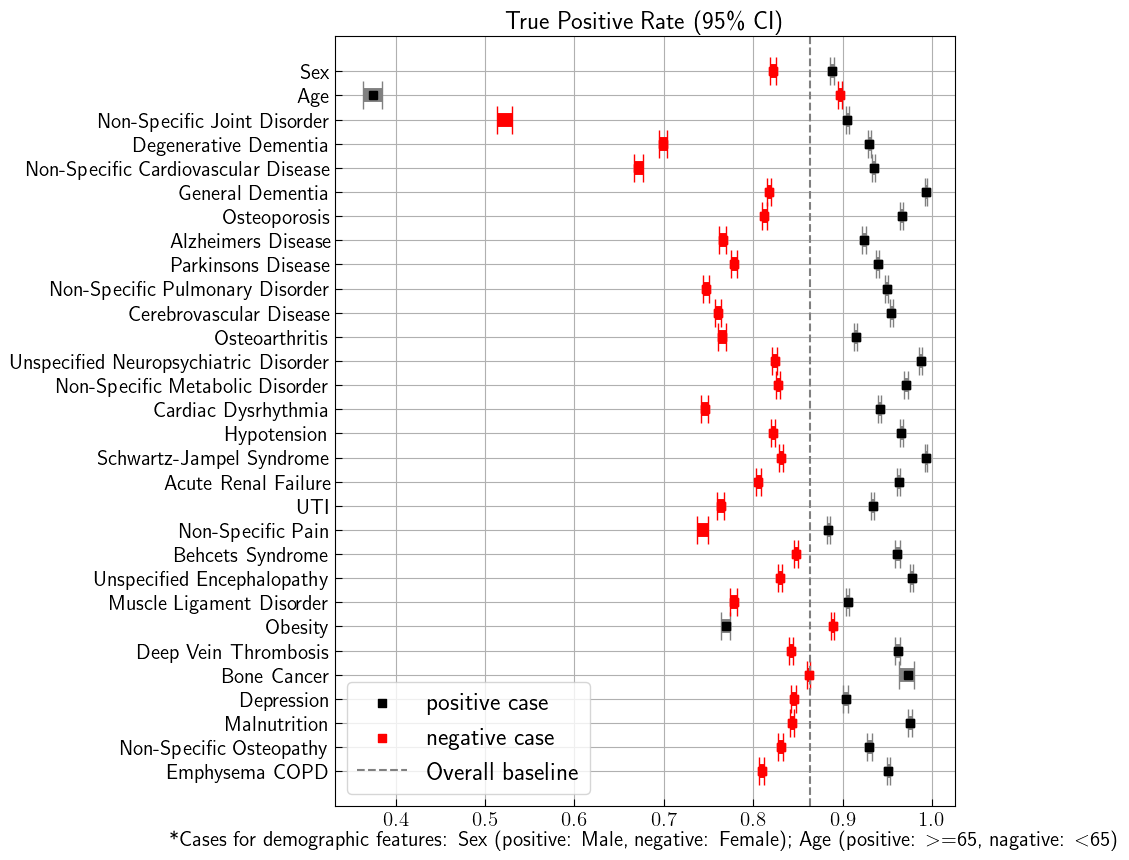

In [28]:
fig, ax = plt.subplots(figsize=(8,10))

ax.scatter(tpr_positive, y_label_positive, marker='s',color='black', label="positive case")
ax.errorbar(tpr_positive, y_label_positive, xerr=[tpr_positive_lower, tpr_positive_upper], fmt='s', color='black', ecolor='gray', elinewidth=10, capsize=10)

ax.scatter(tpr_negative, y_label_negative, marker='s',color='red', label="negative case")
ax.errorbar(tpr_negative, y_label_negative, xerr=[tpr_negative_lower, tpr_negative_upper], fmt='s', color='red', ecolor='red', elinewidth=10, capsize=10)

ax.axvline(x=0.864, color='grey', linestyle='--',label = "Overall baseline")
# Set labels and title
ax.set_title('True Positive Rate (95\% CI)')

# Set legend
ax.legend(loc="lower left")

# Add text annotation at the bottom
note_text = "*Cases for demographic features: Sex (positive: Male, negative: Female); Age (positive: $>$=65, nagative: $<$65)"
ax.text(0.5, -0.05, note_text, transform=ax.transAxes, ha='center')

# Show the plot
ax.grid()
plt.show()

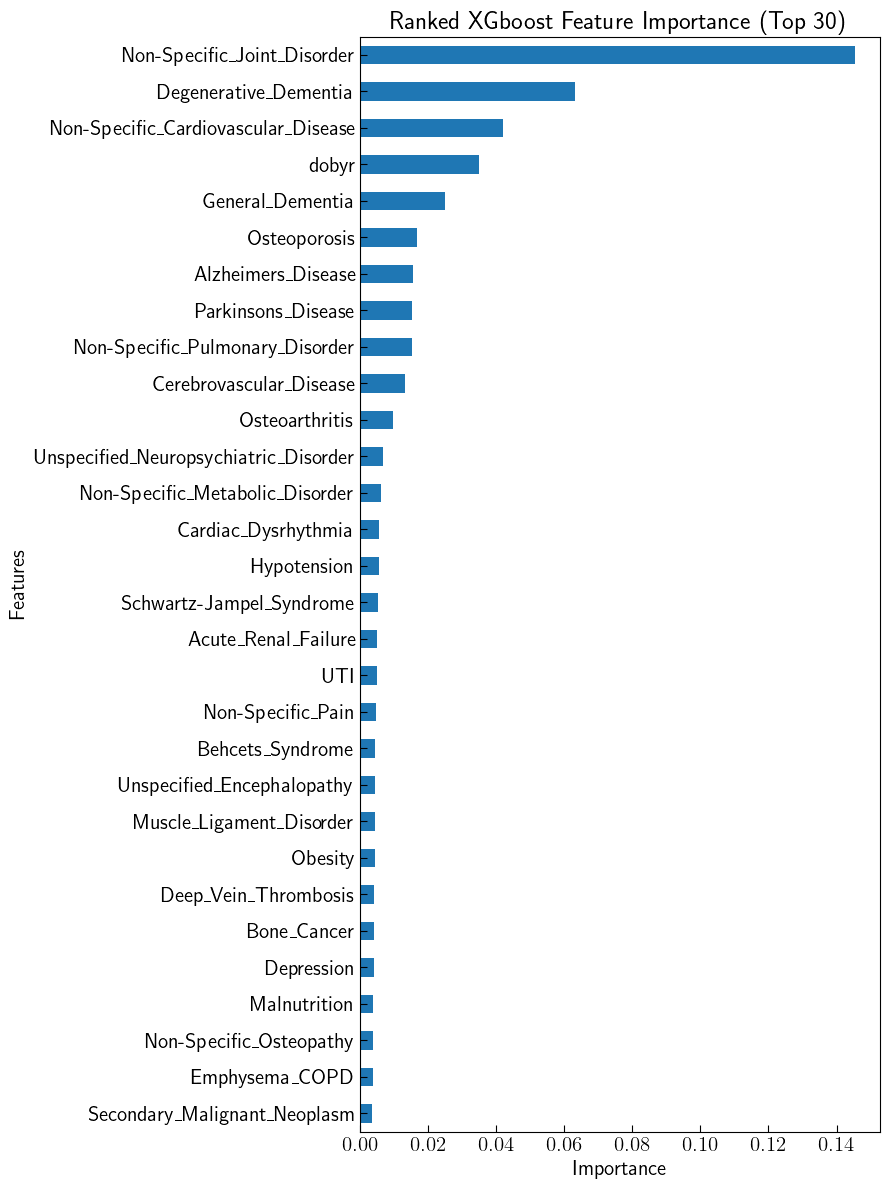

In [37]:
df_xgb_w.sort_values(by = "weight", ascending=True, inplace = True)

fig, ax = plt.subplots(figsize=(8, 15))
df_xgb_w.set_index("Disease").iloc[-30:].plot.barh(y='weight', ax=ax, legend=False)

# Set plot title and axis labels
ax.set_title('Ranked XGboost Feature Importance (Top 30)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')

# Set tick label size
ax.tick_params(axis='both', which='major')

# Adjust plot margins
plt.subplots_adjust(left=0.25, bottom=0.15)

In [70]:
df.sort_values(by = "odds_ratio", ascending=False, inplace=True)
df_xgb_w.sort_values(by = "weight", ascending=False, inplace=True)

df = df.reset_index()

intersect_elements = np.intersect1d(df['disease'].head(50), df_xgb_w['Disease'].head(50))
df_top_features = {'disease': [], 'feature_importance_rank': [], 'odds_ratio_rank': []}
for ele in intersect_elements:
    df_top_features['disease'].append(ele)
    df_top_features['feature_importance_rank'].append(df_xgb_w['weight'].index[df_xgb_w['Disease'] == ele].values[0])
    df_top_features['odds_ratio_rank'].append(df['odds_ratio'].index[df['disease'] == ele].values[0])
    
df_top_features = pd.DataFrame.from_dict(df_top_features)

In [71]:
df_top_features

,disease,feature_importance_rank,odds_ratio_rank
0,Alzheimers_Disease,6,5
1,Behcets_Syndrome,19,33
2,Bone_Cancer,24,9
3,Degenerative_Dementia,1,6
4,General_Dementia,4,2
5,General_Paralysis,38,16
6,Hypotension,14,22
7,Osteoporosis,5,41
8,Parkinsons_Disease,7,3
9,Schwartz-Jampel_Syndrome,15,1


In [72]:
df_top_features.to_html(figure_path / 'top50_features_on_both_table.html', index=True, classes='table table-striped')